In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATETIME   4177 non-null   object 
 1    L_T1      4177 non-null   float64
 2    L_T2      4177 non-null   float64
 3    L_T3      4177 non-null   float64
 4    L_T4      4177 non-null   float64
 5    L_T5      4177 non-null   float64
 6    L_T6      4177 non-null   float64
 7    L_T7      4177 non-null   float64
 8    F_PU1     4177 non-null   float64
 9    S_PU1     4177 non-null   float64
 10   F_PU2     4177 non-null   float64
 11   S_PU2     4177 non-null   float64
 12   F_PU3     4177 non-null   float64
 13   S_PU3     4177 non-null   float64
 14   F_PU4     4177 non-null   float64
 15   S_PU4     4177 non-null   float64
 16   F_PU5     4177 non-null   float64
 17   S_PU5     4177 non-null   float64
 18   F_PU6     4177 non-null   float64
 19   S_PU6     4177 non-null   float6

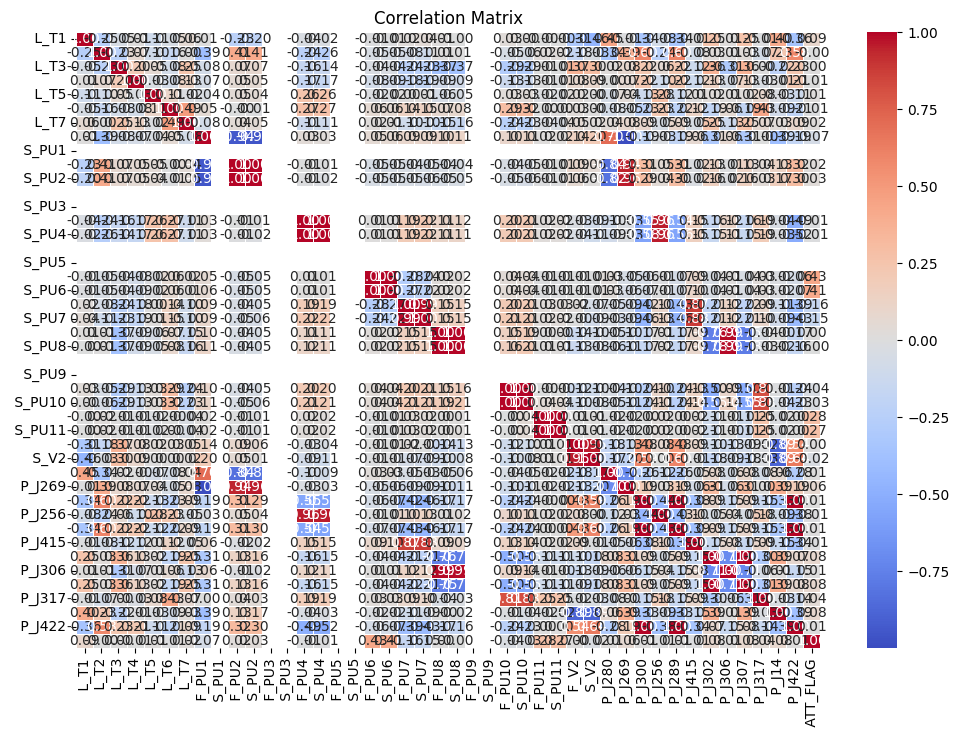

In [ ]:
def explore_data(dataframe):
    # Drop the 'DATETIME' column before calculating correlation
    dataframe_numeric = dataframe.drop(columns=['DATETIME'])
    print("Data Overview:")
    print(dataframe.info())
    print("\nMissing values in each column:")
    print(dataframe.isnull().sum())
    print("\nBasic statistics:")
    print(dataframe.describe())

    # Correlation heatmap
    correlation_matrix = dataframe_numeric.corr()  # Use the numeric DataFrame
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# Data exploration on the training dataset
explore_data(dataframe_train)

In [ ]:
def preprocess_data(dataframe, label_column_index):
    # Extract and drop datetime column
    datetime_column = dataframe.iloc[:, 0]  # the first column is datetime
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)

    # Replace -999 with 0
    dataframe = dataframe.replace(-999, 0)

    # Separate features and labels
    data = dataframe.drop(dataframe.columns[label_column_index], axis=1)
    labels = dataframe.iloc[:, label_column_index].astype(int)

    # Normalize features
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return datetime_column, normalized_data, labels

# Preprocess datasets
_, train_data, train_labels = preprocess_data(dataframe_train, -1)
_, test_data, test_labels = preprocess_data(dataframe_test, -1)

In [ ]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient for RBF
    'kernel': ['linear', 'rbf', 'poly']  # Different kernel options
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

best_svm_model = grid_search.best_estimator_


Best parameters from GridSearchCV:
{'C': 1, 'gamma': 1, 'kernel': 'poly'}


In [ ]:
# Evaluate on the validation set
val_predictions = best_svm_model.predict(X_val)
print("\nValidation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, val_predictions))
print("Precision:", precision_score(y_val, val_predictions))
print("Recall:", recall_score(y_val, val_predictions))
print("F1 Score:", f1_score(y_val, val_predictions))
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, val_predictions))


Validation Set Metrics:
Accuracy: 0.9736842105263158
Precision: 0.7045454545454546
Recall: 0.775
F1 Score: 0.7380952380952381

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       796
           1       0.70      0.78      0.74        40

    accuracy                           0.97       836
   macro avg       0.85      0.88      0.86       836
weighted avg       0.98      0.97      0.97       836



In [ ]:
cross_val_scores = cross_val_score(best_svm_model, train_data, train_labels, cv=5)
print("\nCross-validation scores on the training set:")
print("Accuracy per fold:", cross_val_scores)
print("Mean cross-validation accuracy:", np.mean(cross_val_scores))


Cross-validation scores on the training set:
Accuracy per fold: [0.94019139 0.95095694 0.95209581 0.9508982  0.92934132]
Mean cross-validation accuracy: 0.9446967309400337


In [ ]:
# Train the Model and Evaluate on Test Set
best_svm_model.fit(train_data, train_labels)
test_predictions = best_svm_model.predict(test_data)

print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(test_labels, test_predictions))
print("Precision:", precision_score(test_labels, test_predictions))
print("Recall:", recall_score(test_labels, test_predictions))
print("F1 Score:", f1_score(test_labels, test_predictions))
print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_predictions))


Test Set Metrics:
Accuracy: 0.28769746290090953
Precision: 0.17692767483562463
Recall: 0.7272727272727273
F1 Score: 0.2846153846153846

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.73      0.18      0.29      1682
           1       0.18      0.73      0.28       407

    accuracy                           0.29      2089
   macro avg       0.46      0.45      0.29      2089
weighted avg       0.62      0.29      0.29      2089



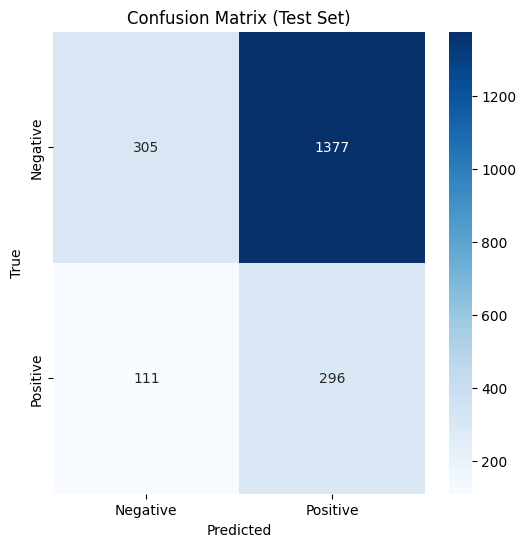

In [ ]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()